<a href="https://colab.research.google.com/github/Araz-AI/Multilayer-Neural-Network-Python-Forward-Backward-prop-plus-Gradient-Descent-Weight-Initialization/blob/main/Multilayer_Neural_Network_from_first_principles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#Multilayer Neural Network Forward, Backward Propagation from First Principles with Xavier/He Initialization and Adam, and RMS Prop Optimizers
#By Araz Jahani, Jan 2021
#This work uses some of the code and concepts from Andrew NG's DeepLearning Course
#The Backward propagation is only implemented for Sigmoid function only.  The code for Back propgation of Softmax is not included here.  As a result, this code is only to be used for Sigmoid (Binary classification between 0 and 1 labels)


In [34]:
#Importing Libraries to be used by the program
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
import sklearn
import sklearn.datasets
import math
import tensorflow as tf
import PIL
from PIL import Image
from numpy import asarray
import numpy as np
import matplotlib.image as mpimg
import math



#From Andrew NG course  (Cat Versus "Non Cat")
def load_data():
    train_dataset = h5py.File('/content/drive/My Drive/ColabNotebooks/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/My Drive/ColabNotebooks/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [35]:
def Sigmoid(z):
    #Sigmoid function calculates the Sigmoid of the matrix X received and would output the sigmoid (x)
    sigmoid = tf.divide(1,(1+tf.exp(-z)))
    return sigmoid

In [36]:
def tanh(z):
    #tanh function implements the activation function for tanh
    tanh = tf.divide((tf.exp(z)-tf.exp(-z)),(tf.exp(z)+tf.exp(-z)))
    return tanh

In [37]:
def Relu(z):
    relu = tf.maximum(0,z)
    return relu

In [38]:
def LeakyRelu(z, alpha=0.01):
    #Alpha is by default set at 0.01, however you can also change this variable to suite the degree of "Leakiness" that you prefer
    Leakyrelu = tf.maximum(alpha*z,z)
    return Leakyrelu

In [39]:
def sigmoid_backward(dA, Z):
  #Calculating Backward propagation for the Sigmoid function
  
  sigmoid = Sigmoid(Z)  #Calculating Sigmoid Activation function of the last node of the Neural network (the output node)

  #Below is the calculation of the Sigmoid Backprop
  dZ = dA * sigmoid * (1-sigmoid)
  return dZ


In [40]:
def relu_backward(dA, Z):

    dZ = np.array(dA) # Copying dA into a new Array dZ

    #Any values that appear in Z that are below or equal to zero, the correspoding values in dZ are set to 0
    #Please note an efficient implementation of this is vectorized and the below two for loops is not a good practice nor is it efficient
    #I used double for loops to demonstrate how logically its implemented but please feel free to change to "Vectorized implementation"
    for i in range(0,dZ.shape[0]):
      for j in range (0,dZ.shape[1]):
        if(Z[i][j]<=0):
          dZ[i][j]=0
    return dZ

In [41]:
#the following code is from Andrew NG assignments in Deep learning.
#The below code is using the relu_backward(dA, Z) and the sigmoid_backward(dA, Z) implemented earlier
def linear_backward(dZ, A_prev, W, b):
    
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ, np.transpose(A_prev))
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, A_prev,W,b,Z, activation):
   
   #Over here we are checking where is our program running in the Neural network. 
   #if the program is running at a node where Relu activation was used then we calculate Relu's backward prop
    if activation == "relu":
        dZ = relu_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
   #Same as the the Relu case (above), if our activation was Sigmoid, we would use the Sigmoid backward function

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
      
    #If you Choose to Implement Softmax, i suggest you include an elif statement to check if the activation was Softmax
    #in this case we have planned not ot implement with Softmax so i have not included checking for "Softmax" here
    return dA_prev, dW, db

In [42]:
def softmax (z):
  #i have included the calculation of Softmax function here.
  #Just to repeat again that we are not going to use Softmax in this program
  #if you choose to use softmax, you need to implement the BAckward propagation for Softmax as well
    t=np.exp(z-np.max(z))
    sum=np.sum(t, axis=0, keepdims=True)
    softmax = np.divide(t,sum)
    return softmax


In [75]:
def parameter_initialization (layer_dimension, initialization="random"):
    #This Function is used to initialize the parameters (Weights = W, and Bias = b) for the entire network depending on the architeture that you choose
    #Receives a list of the Neural network dimensions as a list.  
    # so if layer_dimension = [5,10,1], this means that the NN has 3 layers (1 input layer of size 5 (no parameters here), 1 hidden of size 10 and 1 output layers with size 1
    #The initialization could be just Random, xavier or He inidicated by the "initialization" argument.  if user doesnt specify any argument, the default is just a random initialization
    #The initialization of parameters W (weights) and b (bias) are initialized at random so they are as close to one (1).  
    #This will help to make the Gradient decent converge faster and does not let the W b to be either very small or very large (Vanishing or Exploding gradients)
    

    
    number_of_layers=len(layer_dimension)
    parameters = {} #This is the dictionary holding parameters W and b.   As you would see in the implementation below, the dictionary "W1" corresponds to the Weight matrix of Layer 1

    #The following if statements looks at what initialization in put we have chosen and initializes Weights.  the Biases are initialized to a Zero Vector
    if (initialization=="random"):   #Random Initialization
        for l in range(1,number_of_layers):
            parameters['W' + str(l)] = (np.random.randn(layer_dimension[l], layer_dimension[l-1]))*0.1
            print("min W[",l,"] is: ",np.min(parameters['W' + str(l)]))
            print("max W[",l,"] is: ",np.max(parameters['W' + str(l)]))
            parameters['b' + str(l)] = np.zeros((layer_dimension[l], 1))
    elif (initialization=="xavier"): #Xavier Initialization
        for l in range(1,number_of_layers):
            parameters['W' + str(l)] = np.random.randn(layer_dimension[l], layer_dimension[l-1]) * np.sqrt(np.divide(2,np.add(layer_dimension[l-1],layer_dimension[l])))
            print("min W[",l,"] is: ",np.min(parameters['W' + str(l)]))
            print("max W[",l,"] is: ",np.max(parameters['W' + str(l)]))
            parameters['b' + str(l)] = np.zeros((layer_dimension[l], 1))
    elif (initialization=="He"):   #He Initialization
        for l in range(1,number_of_layers):
            parameters['W' + str(l)] = np.random.randn(layer_dimension[l], layer_dimension[l-1]) * np.sqrt(np.divide(2,layer_dimension[l-1]))
            parameters['b' + str(l)] = np.zeros((layer_dimension[l], 1))   
                                                                                                   
    #returning Parameter dictionary     
    return parameters
    
    
    

In [44]:
def Forward_prop_per_Layer(x,w,b, activation, Dropout_prob = 1):
  #This function calculates the forward propagation for each node depending on an activation (ex: Relu, or Sigmoid)
  #The function receives the initial input Matrix X (or equivalent of A matrix if you are in a hidden layer) and corresponding W (Weights) and Bias (b)
  #'activation' is an argument that indicates what type of activation function is used at this node (ex: Relu or Sigmoid)
  #the Dropout probability is an argument indicating regularization using Dropout.  The dropout argument will set some of the Activation matrix (A) to Zero
  #Drop out is one of the mechanisms to ensure we don't Overfit our model
  #please note that Softmax is reflected here but the backward propagation is not implemented and hence its not used in the entire program
  #As a reminder, if you choose to use "Softmax" you need to then implement the backward propagation for Softmax function


    
    #Calculating the Z Value
    z = tf.add(tf.matmul(w,x),b)
    a=z
    
    #initializing Dropout Matrix in case Dropout prob is less than 1
    Dropout = np.random.rand(a.shape[0],a.shape[1])

    if (activation=="Relu"):
        a = Relu(z)
        # Calculating Relu Activation
          
    if (activation=="LeakyRelu"):
        a = LeakyRelu(z)
        # Calculating LeakyRelu Activation
        
    if (activation=="Sigmoid"):
        a = Sigmoid(z)
        # Calculating Sigmoid Activation
        
    if (activation=="Tanh"):
        a = tanh(z)
        # Calculating Tanh Activation (you need to include a function for backward prop if you want to use this activation)        
        
    if (activation=="Softmax"):
        a = softmax(z)
        # Calculating Softmax Activation (you need to include a function for backward prop if you want to use this activation)        

    #The Dropout is calculated in the event that the Dropout Probability is below 100% (or below '1' in this case)    
    if (Dropout_prob<1 and activation!="Sigmoid"):

        Dropout = (Dropout < Dropout_prob).astype(np.float)
        a = tf.multiply(a,Dropout)
        a = tf.divide(a,Dropout_prob)


    return a,z,Dropout
        


In [45]:
def Forward_prop_End_to_End(X, y, layer_dimension_list,parameters, activation_list,lambda_reg=0,Dropout_prob = 1):
    #This function uses forward propagation at each node which is implemneted in function: def Forward_prop_per_Layer(x,w,b, activation, Dropout_prob = 1)
    #This function calculates the forward E2E propagation of the Neural Network
    #the inputs are X matrix (The initial input matrix), y labels (True labels), layer_dimension_list (the list containg nodes at each layer), activation_list (list of Activation used at each layer)
    #lambda_reg --> lambda regularization parameter if you choose to prevent overfitting of the model
    #Dropout_prob --> Another mechanism to prevent overfitting if the probability is less than 100% (or below 1)

    A_prev = X                    #assigns the input Activation matrix to A_prev
    L=len(layer_dimension_list)   #Captures the length of the layers in the NN
    cache = {}                    #Cache dictionary which stores the Values of Activation Matrices A and also Z matrices
    Dropout_cache={}              #Captures the dropout matrix D
    Reg_cost=0                    #sets regularization cost to 0
    cost=0                        #sets initial cost to 0
    m=A_prev.shape[1]             #caputures the number of samples (m) from the y-axis of the Activation Matrix
    
    for i in range (1, len(layer_dimension_list)):
        #This section of the code (For loop), calculates the Activation at each node using Weights, Biases and stores the Z and A matrix into the Cache
        A,Z,D = Forward_prop_per_Layer(A_prev,parameters['W' + str(i)],parameters['b' + str(i)], activation_list[i],Dropout_prob)
        cache['A' + str(i)]=A
        cache['Z' + str(i)]=Z
        
        A_prev=A 
        Dropout_cache['D' + str(i)]=D   #Stores D in Dropout_cache.. If Dropout is NOT used, then this Matrix would not be used 
        Reg_cost= Reg_cost+Regularization_Cost(parameters['W' + str(i)], lambda_reg)   #calculating Regularization Cost. If regularization is NOT used, this cost is Zero


 
    if (activation_list[-1]=="Sigmoid"): 
      #Binary Cross Entropy Cost
      cost = Cost(cache['A' + str(L-1)],y) + Reg_cost
      
    if (activation_list[-1]=="Softmax"): 
      #As a reminder again, This is just a placeholder in case you want to Use Softmax.  If you Choose to use Softmax, I suggest you implement the backward propagation for it
      #categorical Cross Entropy Cost should be used for Softmax
      cost=cross_entropy_cost(cache['A' + str(L-1)],y)

    return cost, cache,Dropout_cache
    
    

In [46]:
def Regularization_Cost(W, lambda_reg):
    #This function calculates the regulization cost which is the Frobenius norm for the sum of Matrices W at each layer
    #the regularization cost will be added to the overall cost if Regularization is used
    #if not Regularization is used, therefore "lambda_reg" will be set to Zero and will make the Reg_cost (below) Zero as well.
    Reg_cost = lambda_reg/(2*(W.shape[1])) * (np.sum(tf.square(W)))
    return Reg_cost

In [47]:
def Cost(A_prev,y):
    #this function calculates the cost based on the difference between the A-Matrix output from the last layer of the Neural network and the True label (y matrix)
    #Binary Cross Entropy Cost used for Sigmoid Activation function
    #A_prev matrix is a matrix as a result of Sigmoid Activation function from last node of the NN

    m = y.shape[1]    #Capturing size of the samples from true label matrix (y)
    cost1 = np.multiply(-np.log(A_prev),y)
    cost2 =  np.multiply(-np.log(1-A_prev), 1 - y)

    cost = (1./m)*np.nansum(cost1+cost2)  #Useful Note here:  Nansum would ignore the 'nan' output of the logarithm function of a zero
    return cost

In [48]:
def cross_entropy_cost(A,y):
  #categorical Cross Entropy loss used for Softmax
  #as a reminder again, we are not implementing the entire NN with softmax, so i encourage you to revise and implement this code with Softmax as well
  #A is the activation matrix as a result of Softmax output
    
    epsilon=1e-12 #This is to avoid calculating log of zero
    m = y.shape[0]
    log_prob = -np.log(A[range(m),y]+epsilon)
    Categorical_loss = np.sum(log_prob) / m
    return Categorical_loss
    

In [49]:
def FirstLayer(num_nodes, label, activation="null"):
    #This is used in structuring the First layer
    return num_nodes,label,activation
    

In [50]:
def Layer(num_nodes, label, activation):
    #This layer returns the number of nodes and activations that are responsible to construct the network (except for the first layer)
    return num_nodes,label,activation

In [51]:
def add_Layer_sequence(Layer, cache):
    Cache.append(Layer)
    return Cache

In [52]:
def normalizeData(x):
  #this function is used to normalize the data.  It is useful if some of the data is on a different scale
  #ex: your data contains housing prices in the millions but your number of bedrooms are between 1 through 10.  As a result, your data is not on the same scale and needs to be normalized
  
  mean = np.mean(x)
  stddev = np.std(x)
  normalized = np.divide(np.subtract(x,mean),stddev)
  return normalized

In [53]:
def Back_prop_per_Layer(x,y,parameters, cache, Dropout_cache, lambda_reg, Dropout_prob = 1):
    #calculates End to End back propagation for the Neural Network given parameters dictionary, input matrix (x), true label vector (y), Drop_cache matrix (if Dropout was applied) and regularization parameter Lambda
    #The outputs of this function are gradients dA, dZ, dW and db which will be used in the gradient decent calculations

    #initialization of dictionary gradients to store gradients. Similar to the format used in "parameters" the gradient at each layer is added to the dictionary keys (ex: dZ3 refers to the dZ at layer #3)
    gradients = {}  

    #Allocating Lists corresponding to each matrix D from Dropout_cache
    D=[]

    #calculating the length of the items in Cache
    L_cache = len(cache)
    L= int(L_cache/2) 

    #Storing the x (input matrix) in A0
    cache['A' + str(0)]=x
    
    #capturing length of dictionary parameters
    P = len(parameters)

    m = x.shape[1]

    #First Starting from the output of the last node and calculating the delta between true labels and the output of the Neural network (Matrix A)
    dAL = - (np.divide(y, cache['A' + str(L)]) - np.divide(1 - y, 1 - cache['A' + str(L)]))

    #capturing the output of the "linear_activation_backward" function and capturing the gradients dA,dW and db of the Sigmoid function
    #Please note that if you are going to implement Softmax, then you need to implement Softmax backprop code in the "linear_activation_backward" function and change the last argument of this function to "Softmax"
    gradients["dA" + str(L-1)], gradients["dW" + str(L)], gradients["db" + str(L)] = linear_activation_backward(dAL,cache['A' + str(L-1)],parameters["W"+ str(L)],parameters["b"+ str(L)],cache['Z' + str(L)], "sigmoid")

   
    #Now that we have captured the backprop for the Sigmoid function above, lets loop through all the remaining layers (going backward) and calculating the gradients dA, dW, and db
    for i in range(L-1,0,-1): 
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(gradients["dA" + str(i)],cache['A' + str(i-1)],parameters["W"+ str(i)],parameters["b"+ str(i)],cache['Z' + str(i)], "relu")

        if((i-1)!=0):  #I have put this if statement so to avoid the dA0
          gradients["dA" + str(i-1)] = dA_prev_temp
          if (Dropout_prob<1): 
            D = np.random.rand(gradients['dA' + str(i-1)].shape[0],gradients['dA' + str(i-1)].shape[1])              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
            D = (D < Dropout_prob).astype(int) 
            gradients['dA' + str(i-1)] = np.multiply(gradients['dA' + str(i-1)],Dropout_cache['D' + str(i-1)]) 
            gradients['dA' + str(i-1)] = gradients['dA' + str(i-1)]/Dropout_prob                                      # Step 2: Scale the value of neurons that haven't been shut down
        
        gradients['dW' + str(i)] = dW_temp
        gradients['db' + str(i)] = db_temp
     
        
      
    return gradients

In [54]:
def gradient_decent(parameters,gradients,alpha,GD_Type="GD", B1=0.9,B2=0.999, epsilon=1e-8,t=1):
  #The purpose of this function is to calculate Gradient Decent
  #There are three options included:  a)simple Gradient Decent (default), b) RMSProp and c)ADAM --> indicated by GD_Type
  #for Adam B1, B2 and epsilon are used
  #This function accepts arguments for parameters and the gradients calculated in the "Back_prop_per_Layer" Function and will output the update Parameter Weights and biases
  #These new Parameters Weights (W) and biases (b) will then be used to calculate/predict a new Matrix A at the sigmoid layer of the neural network

    #Defining Length of Parameter dictionary containing current values of Weights (W) and Biases (b)
    L=int(len(parameters)/2)

    #Creating new dictionaries to facilitate calculations for RMSProp and ADAM optimizers
    v={}
    s={}
    V_Corrected={}
    S_Corrected={}

    #Creating and Initializing gradient matrix placeholders in our V and S dictionaries as Zero Numpy Arrays    
    for i in range(1,L+1):   
        v["dW" + str(i)] = np.zeros((parameters["W" + str(i)]).shape)
        v["db" + str(i)] = np.zeros((parameters["b" + str(i)]).shape)
        s["dW" + str(i)] = np.zeros((parameters["W" + str(i)]).shape)
        s["db" + str(i)] = np.zeros((parameters["b" + str(i)]).shape)
     
        
   
    for i in range(1,L+1):   #Looping through all the layers  to update corresponding values for Weights (W) and Biases (b) 
        
        if(GD_Type=="RMSProp"):   #This Block calculates RMSProp

            s["dW" + str(i)] = B2*s["dW" + str(i)]+(1-B2)*np.power(gradients['dW' + str(i)],2)
            s["db" + str(i)] = B2*s["db" + str(i)]+(1-B2)*np.power(gradients['db' + str(i)],2)
            parameters['W' + str(i)]=parameters['W' + str(i)]-alpha*(gradients['dW' + str(i)]/(np.sqrt(s["dW" + str(i)])+epsilon))
            parameters['b' + str(i)]=parameters['b' + str(i)]-alpha*(gradients['db' + str(i)]/(np.sqrt(s["db" + str(i)])+epsilon)) 

        if(GD_Type=="ADAM"):     #This Block calculates ADAM
            v["dW" + str(i)] = B1*v["dW" + str(i)]+(1-B1)*gradients['dW' + str(i)]
            v["db" + str(i)] = B1*v["db" + str(i)]+(1-B1)*gradients['db' + str(i)]

            V_Corrected["dw" + str(i)] = v["dW" + str(i)]/(1-np.power(B1,t))
            V_Corrected["db" + str(i)] = v["db" + str(i)]/(1-np.power(B1,t))

            s["dW" + str(i)] = B2*s["dW" + str(i)]+(1-B2)*np.power(gradients['dW' + str(i)],2)
            s["db" + str(i)] = B2*s["db" + str(i)]+(1-B2)*np.power(gradients['db' + str(i)],2)

            S_Corrected["dW" + str(i)] = s["dW" + str(i)]/(1-np.power(B2,t))
            S_Corrected["db" + str(i)] = s["db" + str(i)]/(1-np.power(B2,t))       

            parameters['W' + str(i)]=parameters['W' + str(i)]-alpha*(V_Corrected["dw" + str(i)]/(np.sqrt(S_Corrected["dW" + str(i)])+epsilon))
            parameters['b' + str(i)]=parameters['b' + str(i)]-alpha*(V_Corrected["db" + str(i)]/(np.sqrt(S_Corrected["db" + str(i)])+epsilon)) 
            
            
        if (GD_Type=="GD"):   #This Block calculates simple Gradient Decent which does not have any momentum and will take longer to converge in comparison to ADAM And RMSPROP

            
            parameters['W' + str(i)]=parameters['W' + str(i)]-alpha*gradients['dW' + str(i)]
            parameters['b' + str(i)]=parameters['b' + str(i)]-alpha*gradients['db' + str(i)]
            

            
    return parameters

In [55]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
  #From Andrew NG course
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [56]:
def Convert_to_batches(X, Y, mini_batch_size = 64):
  #From Andrew NG course


    
    np.random.seed(0)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning

    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k* mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k* mini_batch_size : (k+1) * mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
   
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:m]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [57]:
def predict(X,Y,threshold, layer_dimension_list,parameters, activation_list):
  #The purpose of this function is to predict the outcome with the trained parameters
  #The function uses X (input matrix), y(true labels), list of dimensions at each layer, parameters, and list of activations at each layer
  #Please note that in the Predict function, typically Y vector (True labels) is not passed as an argument, but i am passing it here in order to calculate the Accuracy, MSE (Mean Squared Error)
  # in the argument we are also receiving "Threshold" which is basically tells us what should be our prediction cut-off limit.  For example, do we want to curtail values of Matrix A that are above 50%? or above 70%? etc..

  #Using the Standard Forward Prop function to receive cache which contains the last activation Matrix
  cost, cache, Dropout_cache=Forward_prop_End_to_End(X, Y, layer_dimension_list,parameters, activation_list,lambda_reg=0,Dropout_prob = 1)

  #Extracting the Last activation matrix (A) from the cache
  L=len(layer_dimension_list)
  A = cache['A' + str(L-1)]

  m = X.shape[1]
  n=  Y.shape[1]
 
  #creating Matrix P with the same shape as the True label matrix Y (also the dimensions should match the last A matrix)
  p = np.zeros((Y.shape[0],Y.shape[1]))

  # Any probabilities in Matrix A that are above our threshold, we are considering those as '1'.
  #please note that the following code can also be written in a Vectorized version to be more efficient and avoid the O(N2) complexity
  for i in range(0, A.shape[0]):
    for j in range (0,A.shape[1]):
      if A[i,j] > threshold:
        p[i,j] = 1
      else:
        p[i,j] = 0

  #Calculating MSE (Mean Squared Error), Accuracy and Mean Absolute Error
  MSE = (1/n)*np.sum(np.power(np.subtract(Y,A),2))
  Accuracy= np.sum((p == Y)/m)
  MAE=np.sum(np.absolute((p.astype("float") - Y.astype("float"))))

  return p,MSE, MAE, Accuracy

In [58]:

from google.colab import drive
drive.mount('/content/drive/')



X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_data()
print("X_train_orig shape is: ",X_train_orig.shape)
print("Y_train_orig shape is: ",Y_train_orig.shape)

X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

x=X_train
y=Y_train_orig



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
X_train_orig shape is:  (209, 64, 64, 3)
Y_train_orig shape is:  (1, 209)


In [59]:
def Fit_Model (x,y, parameters, layer_dimension,activations,labels, Epochs,learning_rate ,GD_Type="ADAM",threshold=0.5,mini_batch_size = 1,lambda_reg=0,Dropout_prob = 1,B1=0.9,B2=0.999, epsilon=1e-8):
#This function implements the entire forward and backward propagation using the type of Gradient Decent or Optimizer as well as the number of Epochs and Learning Rate (Alpha)
#It takes as inputs, x (the input matrix), y (the true lable), layers_dimension (the list of layers and and number of nodes and corresponding labels and activations)
#Other inputs are: Epochs (number of iterations to achieve optimality in reduction of cost), learning rate (Alpha rate for optimizer), GD_Type (Optimzer type), Threshold (Binary classification threshold)
#other inputs include: Mini_batch_size (by default its set to '1' which represents the Stochastic Gradient Decent (SGD)) and also lambda regularization and Dropout_prob

  #Assigning the number of Epochs to iterations that will be used in our 'for' loop
  iterations=Epochs 
  t=0   

  #creating Cost list so that Cost can be tracked
  cost_tracker=np.empty(iterations)
  cost_tracker_test=np.empty(iterations)
  cost_tracker_mini=[]

  #Creating place holder to track MSE, MAE and Accuracy that we receive from the Predict function
  MSE_Train=np.empty(iterations)
  MSE_Test=np.empty(iterations)
  MAE_Train=np.empty(iterations)
  MAE_Test=np.empty(iterations)
  accuracy_train=np.empty(iterations)
  accuracy_test=np.empty(iterations)


  #Using the Batch functions to feed our data as mini batches instead of one huge batch
  #Please note that the its recommended that we pick our mini batch size in power of 2s.  ex:  32, 64, 128, 256....
  #Also, if you are not using pictures and don't want to use mini batches just comment this code out plus the mini batch second for loop below
  Mini_batch=Convert_to_batches(x, y, mini_batch_size)
  Mini_batch=random_mini_batches(x, y, mini_batch_size)


  #Running our EPOCHS (Iterations)
  for i in range (0,iterations):
    for j in Mini_batch:  #this for loop is intended for mini batch iterations.  Comment this out if you don't want to use mini batches
      (x,y)=j             #comment this line if you don't want to use mini-batches
      
      #calling the End-to-End Forward Propagation function here to capture the Cost, Cache. Cache contains matrices A, Dropout and Z
      cost, cache, Dropout_cache=Forward_prop_End_to_End(x, y, layer_dimension,parameters, activations,lambda_reg,Dropout_prob)
           
      #capturing Cost
      cost_tracker_mini.append(cost)
      cost_tracker[i]=(cost)

      #Calling Backprop function and receiving the gradients    
      grads = Back_prop_per_Layer(x,y,parameters, cache,Dropout_cache,lambda_reg, Dropout_prob )

      t+=1 #updating the iterations for ADAM optimizer

      #Calling the gradient_decent function and using the gradients we have received from the Backprop function to obtain the new parameters
      parameters = gradient_decent(parameters,grads,learning_rate,GD_Type, B1,B2, epsilon,t)
    
    #Calling Predict functions on the Train data as well as the test data to observe the MSE, MAE and Accuracy
    p_train,Mean_squared_Train, MAE_train, Accuracy_train1 = predict(X_train,Y_train_orig,threshold,layer_dimension,parameters, activations)
    p_test,Mean_squared_Test,MAE_test, accuracy_test1 = predict(X_test,Y_test_orig,threshold,layer_dimension,parameters, activations)

    print("\n*Cost for Training data at Epoch:",i,"is: ", cost)

    #Capturing the output of the predict function
    ACC_train = Accuracy_train1
    ACC_test=accuracy_test1

    accuracy_train[i]=ACC_train
    accuracy_test[i]=ACC_test
    MSE_Train[i] = Mean_squared_Train
    MSE_Test[i] = Mean_squared_Test
    MAE_Train[i]=MAE_train
    MAE_Test[i]=MAE_test
    
    #printing Status per Epoch
    print(" Accuracy_Train: ", ACC_train)
    print(" Accuracy_Test: ", ACC_test)
    print(" MSE of Training data at current Epoch is: ",Mean_squared_Train)
    print(" MSE of Test data at current Epoch is: ",Mean_squared_Test)
    print(" MAE of Training data at current Epoch is: ",MAE_train)
    print(" MAE of Test data at current Epoch is: ",MAE_test)

  return cost_tracker,accuracy_train,accuracy_test,MSE_Train,MSE_Test,MAE_Train,MAE_Test



In [77]:
#This is where the actual Code gets executed and the place where we call all of our functions to run all of our functions

#cache to capture the details of our layers
cache=[]  

#Creating the layers.  Please feel free to add more layers or subtract.  you just need to maintain minimum two layers (the First layer and the last_layer)
#Please make sure that for your first layer the input dimensions match the X.shape[0].  The last layer has 1 node and this represents the "Sigmoid" binary output
#if you decide to implement Softmax's backdrop, you can change the last layer to "Softmax" and change the nodes to the different softmax classes, but just as a reminder that you need to implemnt the backward prop for Softmax first
#other activation functions in hidden layers include: "LeakyRelu", "Tanh", 
first_layer = FirstLayer(12288, "First Layer")
second_layer = Layer(100,"Second Layer", "LeakyRelu")
third_layer = Layer(50, "Third Layer","LeakyRelu")
last_layer= Layer(1, "Last Layer", "Sigmoid")

#Adding the Layers in sequence to the cache
#if you add more layers above, please include the name and append them accordingly to the cache below
cache.append(first_layer)
cache.append(second_layer)
cache.append(third_layer)
cache.append(last_layer)


#Defining each list within the Cache so that we can extract these data from the Cache
layer_dimension=[]
activations = []
labels = []

#Extracting the data from the cache
layer_dimension.append(cache[0][0])  
activations.append(cache[0][2])
labels.append(cache[0][1])

for i in range (1, len(cache)):
    layer_dimension.append(cache[i][0])
    activations.append(cache[i][2])
    labels.append(cache[i][1])

#The parameter_initialization function would automatically calculate the dimensions of your W Matrices and will initialize them based on the input you provide
#Other possible initializations are: "He", "xavier" or "random"
parameters=parameter_initialization (layer_dimension, initialization="He")
cost_tracker,accuracy_train,accuracy_test,MSE_Train,MSE_Test,MAE_Train,MAE_Test=Fit_Model (x,y,parameters,layer_dimension,activations,labels,Epochs=1000,learning_rate=0.01 ,GD_Type="GD",threshold=0.5,mini_batch_size = 32,lambda_reg=0.0,Dropout_prob = 1,B1=0.9,B2=0.999, epsilon=1e-8)                          

Streaming output truncated to the last 5000 lines.

*Cost for Training data at Epoch: 375 is:  0.0015561059393910557
 Accuracy_Train:  0.9999999999999998
 Accuracy_Test:  0.78
 MSE of Training data at current Epoch is:  4.081976679055312e-05
 MSE of Test data at current Epoch is:  0.20279431673374493
 MAE of Training data at current Epoch is:  0.0
 MAE of Test data at current Epoch is:  11.0

*Cost for Training data at Epoch: 376 is:  0.0015466678138058494
 Accuracy_Train:  0.9999999999999998
 Accuracy_Test:  0.78
 MSE of Training data at current Epoch is:  4.065197945330566e-05
 MSE of Test data at current Epoch is:  0.20273157459676658
 MAE of Training data at current Epoch is:  0.0
 MAE of Test data at current Epoch is:  11.0

*Cost for Training data at Epoch: 377 is:  0.001541296934117603
 Accuracy_Train:  0.9999999999999998
 Accuracy_Test:  0.78
 MSE of Training data at current Epoch is:  3.9875014185563985e-05
 MSE of Test data at current Epoch is:  0.20263110563642692
 MAE of Tr

(1000,)
0.0003465593765416858
(array([999]),)
[0.00034656]
Minimum Cost:  0.0003465593765416858
shape of cost tracker is:  (1000,)
[0.00034656]
Last cost 0.0003465593765416858


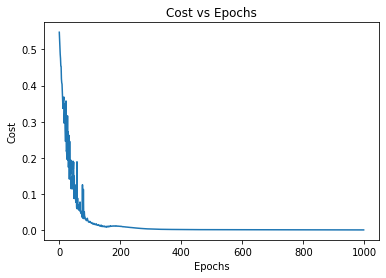

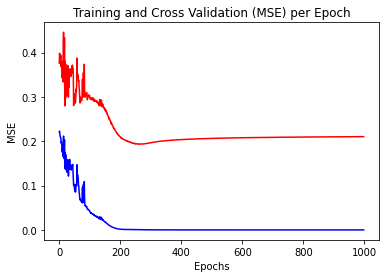

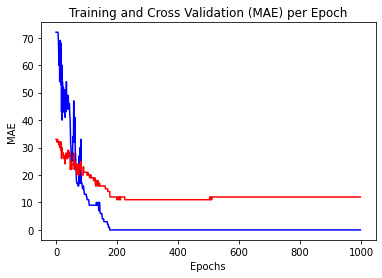

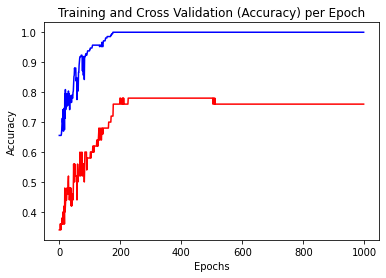

In [78]:
#This part of the code will show the Graphs of the results obtained from the training and predicting of the data

iterations=1000   #Set the iterations to the number of EPOCHS

#Plotting the Cost Versus Epochs graph with labels
plt.title("Cost vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.plot(cost_tracker[1:iterations])




#***********displaying mean squared error per epoch
plt.figure()
plt.title("Training and Cross Validation (MSE) per Epoch")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(MSE_Train[1:iterations],'b')
plt.plot(MSE_Test[1:iterations],'r')
plt.figure()

#***********displaying mean absolute error per epoch
plt.title("Training and Cross Validation (MAE) per Epoch")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.plot(MAE_Train[1:iterations],'b')
plt.plot(MAE_Test[1:iterations],'r')
plt.figure()

#***********displaying Accuracy per epoch
plt.title("Training and Cross Validation (Accuracy) per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(accuracy_train[1:iterations],'b')
plt.plot(accuracy_test[1:iterations],'r')
